<a href="https://colab.research.google.com/github/SalimovAlbert/Faulty-detail/blob/main/Two_class_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title MIT License
#
# Copyright (c) 2020 Salimov Albert                                                                                                                  
# IGNORE_COPYRIGHT: cleared by OSS licensing
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import pathlib
import pandas as pd

from tensorflow.keras.preprocessing import image_dataset_from_directory

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = "/content/drive/MyDrive/Detection"
!rm -f data_dir + "/ipynb_checkpoints"
#!rm -rf find -type d -name .ipynb_checkpoints
data_dir = pathlib.Path(data_dir)

batch_size = 32
img_height = 160
img_width = 160
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  shuffle=True,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  shuffle=True,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 185 files belonging to 2 classes.
Using 148 files for training.
Found 185 files belonging to 2 classes.
Using 37 files for validation.


In [ ]:
train_labels = np.concatenate([labels for _, labels in train_dataset])

In [ ]:
neg, pos = np.bincount(train_labels)
total = neg + pos
initial_bias = np.log(pos/neg)
initial_bias = tf.keras.initializers.Constant(initial_bias)

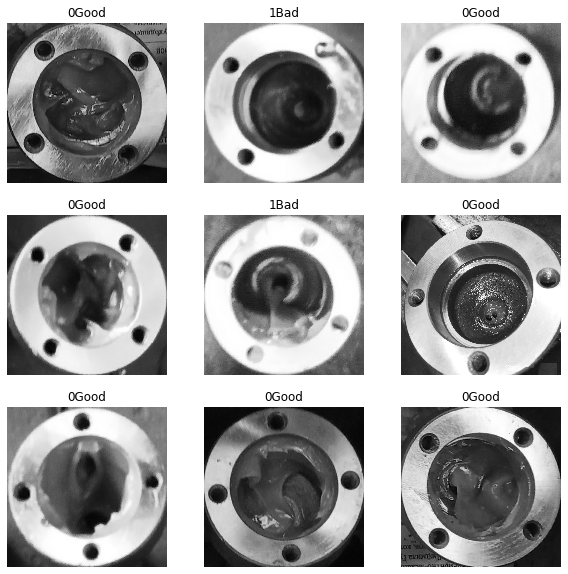

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
      ax = plt.subplot(3, 3, i+1)
      plt.imshow(images[i] / 255)
      plt.title(class_names[labels[i]])
      plt.axis('off')

    

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(np.ceil(val_batches // 5))
validation_dataset = validation_dataset.skip(np.ceil(val_batches // 5))

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 2
Number of test batches: 0


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomContrast(0.2),
  # tf.image.stateless_random_saturation
  # tf.image.stateless_random_brightness
  # tf.image.stateless_random_hue()
  # tf.keras.layers.experimental.preprocessing.RandomCrop(160, 160),
  tf.keras.layers.experimental.preprocessing.RandomRotation(1., fill_mode='constant'),
  # tf.keras.layers.experimental.preprocessing.RandomTranslation(0.15, 0.15, fill_mode='nearest'),

  
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


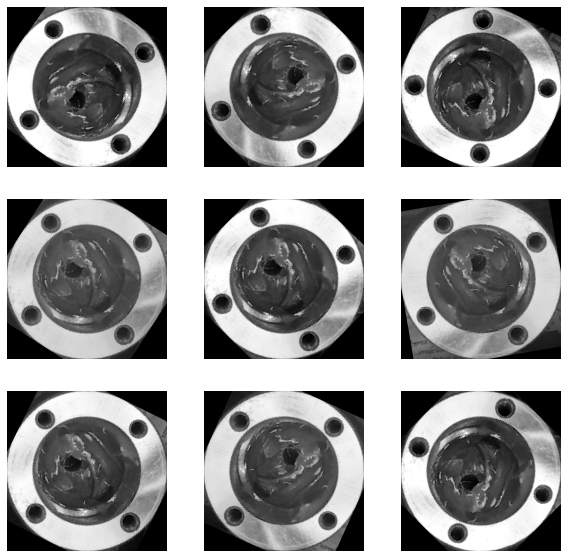

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

In [ ]:
# rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
base_model = tf.keras.applications.MobileNetV2(input_shape=(img_height, img_width, 3),
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


In [ ]:
base_model.trainable = False

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

In [ ]:
prediction_layer = tf.keras.layers.Dense(1,activation=tf.keras.activations.sigmoid, bias_initializer=initial_bias)

In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x =tf.image.stateless_random_brightness(x, 0.1, seed=(0, 0))
# x = tf.image.stateless_random_contrast(x, 0.0, 0.2, seed=(0, 0))
# x = tf.image.stateless_random_hue(x, 0.01, seed=(0,0))
# x = tf.image.stateless_random_saturation(x, 0.0, 0.2, seed=(0,0))
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.25)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

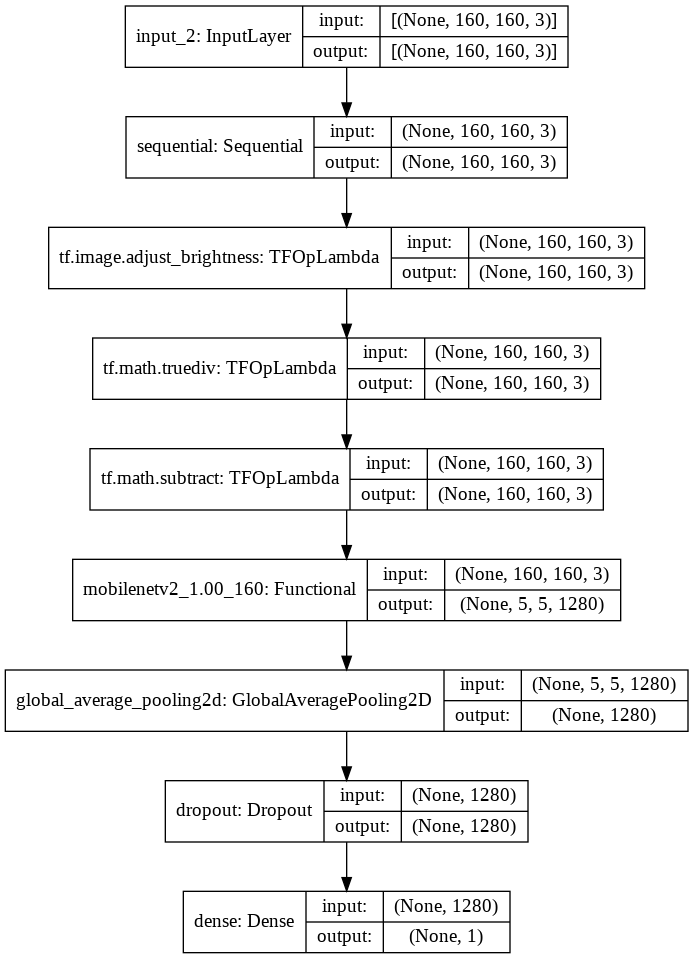

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model=model, show_shapes=True)

In [ ]:
base_learning_rate = 0.003
time_decay = tf.keras.optimizers.schedules.InverseTimeDecay(base_learning_rate, decay_steps=100.0, decay_rate=0.5 )
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=time_decay, clipvalue=0.5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.PrecisionAtRecall(recall=0.9), 'Precision', 'Recall', 'AUC', 'accuracy'])

In [ ]:
initial_epochs = 100

model.evaluate(validation_dataset)

2/2 [==============================] - 53s 99ms/step - loss: 0.6338 - precision_at_recall: 0.2234 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4785 - accuracy: 0.7829


[0.6384629011154175,
 0.2222222238779068,
 0.0,
 0.0,
 0.4719827473163605,
 0.7837837934494019]

In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    #initial_epoch=history.epoch[-1],
                    validation_data=validation_dataset)

Epoch 1/100
5/5 [==============================] - 4s 151ms/step - loss: 0.4903 - precision_at_recall: 0.1507 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.4980 - accuracy: 0.8378 - val_loss: 0.5462 - val_precision_at_recall: 0.4211 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.8254 - val_accuracy: 0.7838
Epoch 2/100
5/5 [==============================] - 1s 83ms/step - loss: 0.3853 - precision_at_recall: 0.1909 - precision: 1.0000 - recall: 0.0455 - auc: 0.7101 - accuracy: 0.8581 - val_loss: 0.4229 - val_precision_at_recall: 0.3636 - val_precision: 1.0000 - val_recall: 0.1250 - val_auc: 0.8836 - val_accuracy: 0.8108
Epoch 3/100
5/5 [==============================] - 1s 84ms/step - loss: 0.2802 - precision_at_recall: 0.3636 - precision: 0.7778 - recall: 0.3182 - auc: 0.8914 - accuracy: 0.8851 - val_loss: 0.4132 - val_precision_at_recall: 0.3478 - val_precision: 1.0000 - val_recall: 0.1250 - val_auc: 0.8728 - val_accuracy: 0.8108
Epoch 4/100
5/5 [============

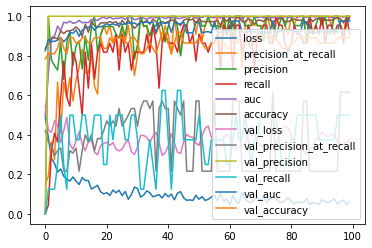

In [ ]:
pd.DataFrame(history.history).plot()

In [ ]:
# !mkdir -p saved_model
model.save('/content/drive/MyDrive/Detection_model.h5')

In [ ]:
# checkpoint_path = "training_1/cp-{epoch:04d}.ckpt"
# os.path.dirname(checkpoint_path)
# model.save_weights(checkpoint_path.format(epoch=4500))

In [ ]:
# base_learning_rate = 0.0003
# lr = tf.keras.optimizers.schedules.InverseTimeDecay(base_learning_rate, decay_steps=100.0, decay_rate=0.5 )
# model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr),#  clipvalue=0.5),
#               loss=tf.keras.losses.BinaryCrossentropy(),
#               metrics=['accuracy', 'AUC', 'Precision', 'Recall'])

In [ ]:
model.evaluate(validation_dataset)

2/2 [==============================] - 0s 18ms/step - loss: 0.3718 - precision_at_recall: 0.6154 - precision: 1.0000 - recall: 0.5000 - auc: 0.9763 - accuracy: 0.8919


[0.3718445897102356,
 0.6153846383094788,
 1.0,
 0.5,
 0.9762930870056152,
 0.8918918967247009]

In [ ]:
from sklearn.metrics import confusion_matrix

### Learning curves

Let's take a look at the learning curves of the training and validation accuracy/loss when using the MobileNet V2 base model as a fixed feature extractor.

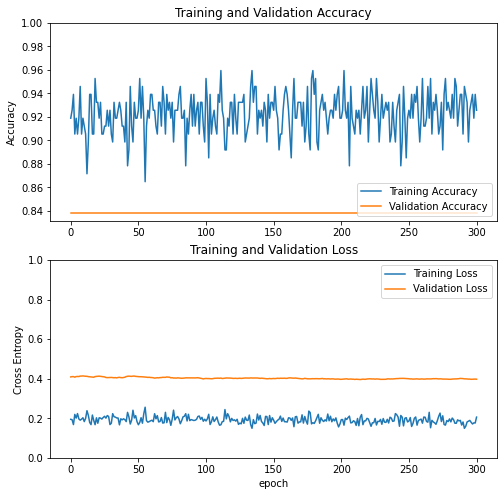

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate/50),
              metrics=[tf.keras.metrics.PrecisionAtRecall(recall=0.9), 'Precision', 'Recall', 'AUC', 'accuracy'])

In [ ]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
tf.image.adjust_brightness_1 (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv_1 (TFOpLambd (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract_1 (TFOpLamb (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0   

In [ ]:
len(model.trainable_variables)

56

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=300, restore_best_weights=True)

In [ ]:
fine_tune_epochs = 300
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset,
                         callbacks = [callback])

Epoch 100/400
5/5 [==============================] - 6s 417ms/step - loss: 0.5417 - precision_at_recall_1: 0.5487 - precision: 0.5758 - recall: 0.9227 - auc: 0.9291 - accuracy: 0.8463 - val_loss: 2.1346 - val_precision_at_recall_1: 0.2162 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5000 - val_accuracy: 0.7838
Epoch 101/400
5/5 [==============================] - 1s 90ms/step - loss: 0.9091 - precision_at_recall_1: 0.1637 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.6985 - accuracy: 0.8363 - val_loss: 0.5069 - val_precision_at_recall_1: 0.2162 - val_precision: 1.0000 - val_recall: 0.1250 - val_auc: 0.8793 - val_accuracy: 0.8108
Epoch 102/400
5/5 [==============================] - 1s 91ms/step - loss: 0.1796 - precision_at_recall_1: 0.6731 - precision: 0.7998 - recall: 0.8402 - auc: 0.9763 - accuracy: 0.9480 - val_loss: 0.3753 - val_precision_at_recall_1: 0.2500 - val_precision: 1.0000 - val_recall: 0.2500 - val_auc: 0.8556 - val_accuracy: 0.8378
Epoch 103/4

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
model.evaluate(validation_dataset)

2/2 [==============================] - 0s 15ms/step - loss: 0.5692 - precision_at_recall_1: 0.2162 - precision: 1.0000 - recall: 0.7500 - auc: 0.8750 - accuracy: 0.9459


[0.5692457556724548, 0.21621622145175934, 1.0, 0.75, 0.875, 0.9459459185600281]

And now you are all set to use this model to predict if your pet is a cat or dog.

Predictions:
 [0 0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0]
Labels:
 [0 0 0 1 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0]


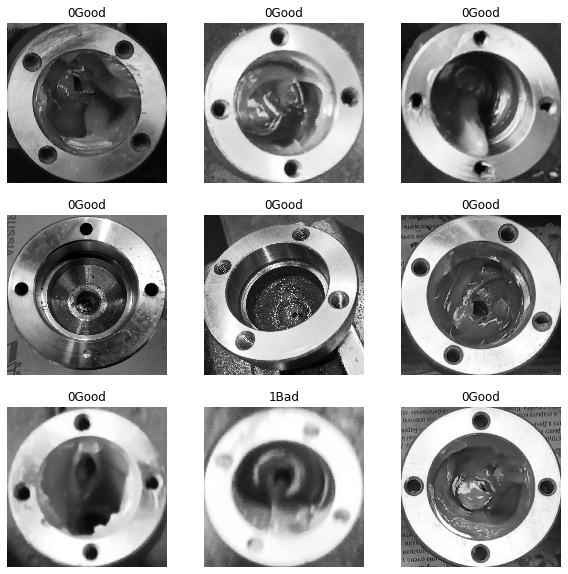

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = validation_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.where(predictions < 0.05, 0, 1)

from sklearn.metrics.classification import classification_report
print(classification_report(label_batch, predictions.numpy()))
print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")

In [ ]:
model.predict(train_dataset)